# Requirements

## Install packages

In [1]:
import sys

!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install tensorflow

Looking in indexes: http://build-nexus.prod.crto.in/repository/pypi/simple
Looking in indexes: http://build-nexus.prod.crto.in/repository/pypi/simple
Looking in indexes: http://build-nexus.prod.crto.in/repository/pypi/simple
Looking in indexes: http://build-nexus.prod.crto.in/repository/pypi/simple
Looking in indexes: http://build-nexus.prod.crto.in/repository/pypi/simple
Looking in indexes: http://build-nexus.prod.crto.in/repository/pypi/simple


## Imports

In [2]:
import wget
import tarfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar
import os
import tensorflow as tf
import random
from functools import reduce
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

## Download dataset

In [3]:
# List files
base_directory = "./instacart_2017_05_01/"
files_location = [base_directory + file_name for file_name in ["orders.csv", 
                                                               "order_products__train.csv", 
                                                               "order_products__prior.csv", 
                                                               "products.csv", 
                                                               "aisles.csv", 
                                                               "departments.csv"]]

# Check if all files have already been downloaded
files_exists = map(lambda f: os.path.isfile(f), files_location)

missing_file = not reduce(lambda f1, f2: f1 and f2, files_exists)

# Download dataset is a file is missing
if missing_file:
    dataset_url = "https://s3.amazonaws.com/instacart-datasets/instacart_online_grocery_shopping_2017_05_01.tar.gz"
    wget.download(dataset_url)
    with tarfile.open("instacart_online_grocery_shopping_2017_05_01.tar.gz", "r:gz") as tar:
        tar.extractall()

# Data exploration

### Import data frames

In [4]:
orders_df, orders_set_train_df, orders_set_prior_df, products_df, aisle_df, departments_df = (pd.read_csv(file_name) 
                                      for file_name in files_location)

### Take a quick look at each dataframes

In [5]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
orders_set_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [8]:
aisle_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### Simple statistics

In [10]:
print("Number of orders          ", len(orders_df))
print("Number of products        ", len(products_df))
print("Number of ordered products", len(orders_set_train_df) + len(orders_set_prior_df))
print("Number of aisle           ", len(aisle_df))
print("Number of department      ", len(departments_df))

Number of orders           3421083
Number of products         49688
Number of ordered products 33819106
Number of aisle            134
Number of department       21


### Join dataframes

In [11]:
all_orders_set_df = pd.concat([orders_set_train_df, orders_set_prior_df])

In [12]:
full_products_df = products_df.merge(aisle_df, on="aisle_id")
full_products_df = full_products_df.merge(departments_df, on="department_id")
full_products_df.head()

,product_id,product_name,aisle_id,department_id,aisle,department
0,1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,cookies cakes,snacks
2,102,Danish Butter Cookies,61,19,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,61,19,cookies cakes,snacks


# Data exploration

In [13]:
float_format = lambda r: [round(x, 2) for x in r] if isinstance(r, list) else round(r, 2)

### Analysis number of order per user

In [14]:
nb_order_per_user = orders_df.groupby(["user_id"]).size().to_frame("nb_order")
nb_order_per_user.describe().apply(float_format)

,nb_order
count,206209.00
mean,16.59
std,16.65
min,4.00
25%,6.00
50%,10.00
75%,20.00
max,100.00


/home/k.villatel/miniconda3/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


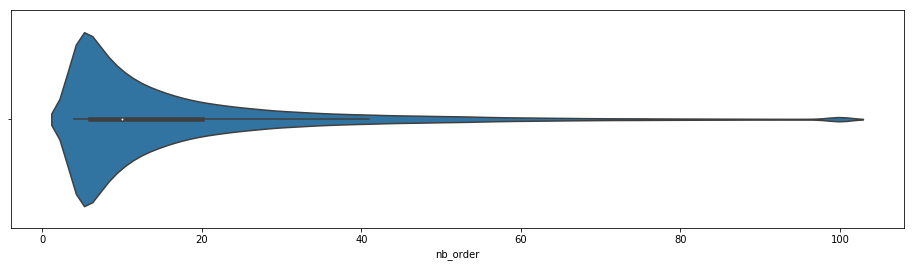

In [15]:
f, ax = plt.subplots(figsize=(16,4))
sns.violinplot(x='nb_order', data=nb_order_per_user, ax=ax)

The dataset contains mostly small number of order per user (median 10, 75th percentile 20). <br/>
Small remark: the small spike observed at the end of the distribution (100 orders) suggests that sequences of orders aith > 100 orders have been cropped to 100 (not filtered out) when creating the dataset. 

### Analysis days between order

In [16]:
orders_df[["days_since_prior_order"]].describe().apply(float_format)

,days_since_prior_order
count,3214874.00
mean,11.11
std,9.21
min,0.00
25%,4.00
50%,7.00
75%,15.00
max,30.00


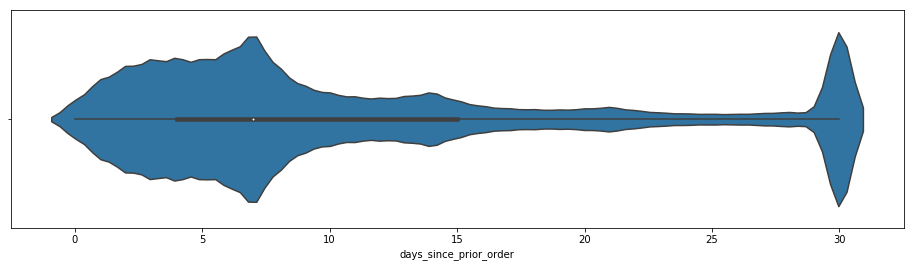

In [17]:
f, ax = plt.subplots(figsize=(16,4))
sns.violinplot(x='days_since_prior_order', data=orders_df, ax=ax)

We expect most people to do the shopping (at least) once a week. The upper graph shows that 50% of the users made an order during the previous week, which math the intuition. The remaining half are probably people not using the service on a regular basis, and are therefore to be convinced! We can also observe a pic on day=30 which is suspicious... days_since_prior_order seems to have been cropped to 30? But why?

### Analysis days / hours of order

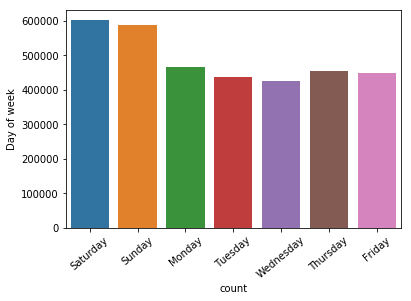

In [18]:
ax = sns.countplot(x="order_dow", data=orders_df)
ax.set(xlabel="count", ylabel="Day of week")
plt.xticks(np.arange(7), np.roll(calendar.day_name, 2), rotation=40)
plt.show()

The above graph shows that days of the week-end receive more orders.

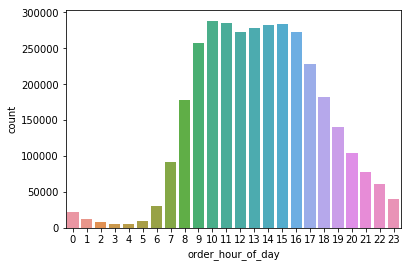

In [19]:
sns.countplot(x="order_hour_of_day", data=orders_df)

The distribution of orders is almost uniform between 10am and 4pm. I would have expected a bimodal distribution, with a mode at noon and a mode in the evening during woking days. Let's see if we project by days.

/home/k.villatel/miniconda3/envs/tensorflow/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


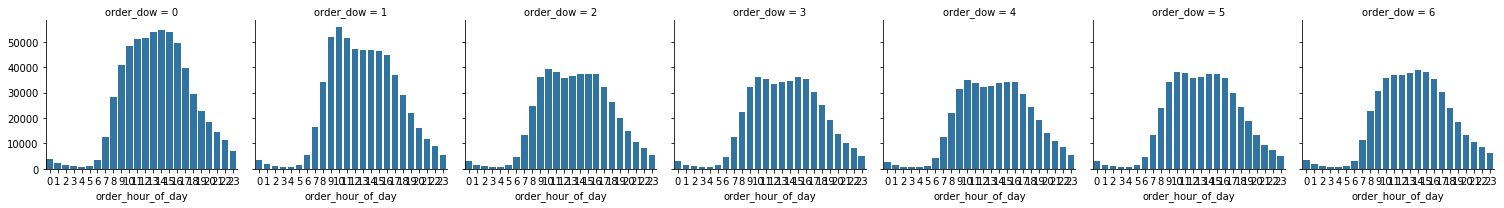

In [20]:
g = sns.FacetGrid(orders_df, col="order_dow")
g = g.map(sns.countplot, "order_hour_of_day")

The shape of the distribution is the same for all days of the week, no difference between working days and week-end as I first hypothetized.

### Analysis time since last order / order size correlation 

We expect that the longer time since last order, the bigger the next order (fridge becomes empty, people gets hungry!) Let's see if data confirm this intuition. <br/>
This step requires a join between orders_df and orders set df, we will down-sample the dataset.

In [21]:
# down-sample dataset and remove first orders (days_since_prior_order NaN) and days_since_prior_order that was suspicious
sample_orders_df = orders_df[orders_df["days_since_prior_order"].notnull() 
                             & (orders_df["days_since_prior_order"] != 30)].sample(500000)

sample_orders_df = sample_orders_df.merge(all_orders_set_df, on="order_id")

In [22]:
# Compute the size of each order
grouped_by_order = sample_orders_df.groupby("order_id")
orders_size_df = grouped_by_order.size().to_frame("order_size")

# Add the number of days since the last order
orders_days_since_last_order = grouped_by_order.first()["days_since_prior_order"]
orders_size_df = orders_size_df.join(orders_days_since_last_order, on="order_id")

In [23]:
orders_size_df.describe()

,order_size,days_since_prior_order
count,490890.000000,490890.000000
mean,10.120821,8.601628
std,7.502529,6.554692
min,1.000000,0.000000
25%,5.000000,4.000000
50%,8.000000,7.000000
75%,14.000000,12.000000
max,108.000000,29.000000


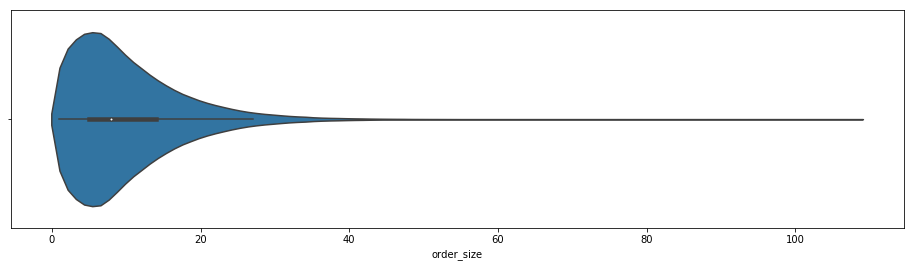

In [24]:
f, ax = plt.subplots(figsize=(16,4))
sns.violinplot(x="order_size", data=orders_size_df, ax=ax)

In [25]:
# Remove tail distribution
orders_size_df = orders_size_df[orders_size_df["order_size"] <= 30]

In [26]:
# Compute average order size per day since last order
mean_order_size_df = orders_size_df.groupby("days_since_prior_order")["order_size"].mean().to_frame("mean_order_size")
mean_order_size_df["days_since_prior_order"] = mean_order_size_df.index

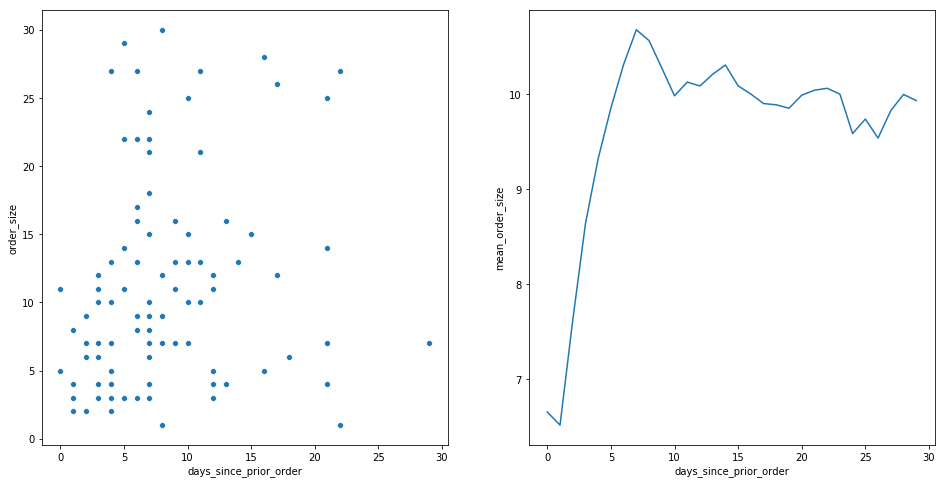

In [27]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
sns.scatterplot(x="days_since_prior_order", y="order_size", data=orders_size_df.sample(100), ax=axes[0])
sns.lineplot(x="days_since_prior_order", y="mean_order_size", data=mean_order_size_df, ax=axes[1])

There is a (rather small and noisy ...) correlation between the number of days since the last order and the order size. <br/>
It seems that there are two regimes. <br/>
Between 1 and 7 days, the size of the order increase linearly with the number of days. <br/>
After 7 days, the size of the order seems to decrease a little bit, also with a linear relationship.
We also observe peaks every 7 days, which is probably related to people habbits to do shopping the same day, every few weeks.

# Modeling of order size

Previous analysis showed that there are linear relation ship between the number of days since the last order and the order size, let's feet those lines to get a simple order size model.

In [28]:
def build_datasets(df):
    X = np.array(df["days_since_prior_order"]).reshape(-1,1)
    y = df["order_size"]

    return train_test_split(X, y)

In [29]:
X_train_full, X_test_full, y_train_full, y_test_full = build_datasets(orders_size_df)

### Baseline: average order size

In [30]:
avg_baseline_predictions = [np.mean(y_train_full)]*len(y_test_full)
avg_baseline_mse = mean_squared_error(y_true=y_test_full, y_pred=avg_baseline_predictions)

### First model: linear model

Fit a simple linear model, serves as a baseline

In [31]:
# Fit a linear model and return mse, intercept and slope
def fit_and_eval_linear_model(X_train, X_test, y_train, y_test):
    model = linear_model.LinearRegression()
    model.fit(X=X_train, y=y_train)

    predictions = model.predict(X=X_test)
    
    return mean_squared_error(y_true=y_test, y_pred=predictions), model.intercept_, model.coef_[0]

In [32]:
model_1_mse, model_1_intercept, model_1_slope = fit_and_eval_linear_model(
                                                                X_train = X_train_full, 
                                                                X_test = X_test_full, 
                                                                y_train = y_train_full, 
                                                                y_test = y_test_full)

### Second model: 2 linear models, one for each regime

Train first linear model on first week

In [33]:
first_week_df = orders_size_df[orders_size_df["days_since_prior_order"] <= 7]

X_train_first_week, X_test_first_week, y_train_first_week, y_test_first_week = build_datasets(first_week_df)

model_2_mse_first_week, model_2_first_week_intercept, model_2_first_week_slope = fit_and_eval_linear_model(
                                                                                    X_train = X_train_first_week, 
                                                                                    X_test = X_test_first_week, 
                                                                                    y_train = y_train_first_week, 
                                                                                    y_test = y_test_first_week)

Train second linear model on last weeks

In [34]:
last_weeks_df = orders_size_df[orders_size_df["days_since_prior_order"] > 7]

X_train_last_weeks, X_test_last_weeks, y_train_last_weeks, y_last_weeks = build_datasets(last_weeks_df)

model_2_mse_last_weeks, model_2_last_weeks_intercept, model_2_last_weeks_slope = fit_and_eval_linear_model(
                                                                                    X_train = X_train_last_weeks, 
                                                                                    X_test = X_test_last_weeks, 
                                                                                    y_train = y_train_last_weeks, 
                                                                                    y_test = y_last_weeks)

Compute final mse as a weighted average of the mse on first week and the mse on next weeks

In [35]:
model_2_mse = np.average(a = [model_2_mse_first_week, model_2_mse_last_weeks], 
                              weights = [len(y_test_first_week), len(y_last_weeks)])

In [36]:
print("Average baseline mse            ", avg_baseline_mse)
print("First model: linear, 1 regime   ", model_1_mse)
print("Second model: linear, 2 regimes ", model_2_mse)

Average baseline mse             41.183133855133754
First model: linear, 1 regime    40.89092804361795
Second model: linear, 2 regimes  40.051460445576915


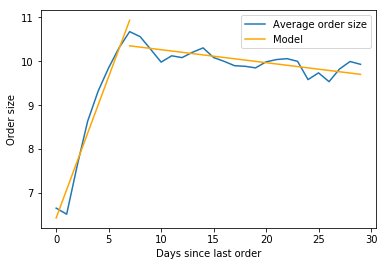

In [37]:
plt.figure()

plt.ylabel("Order size")
plt.xlabel("Days since last order")

X=np.arange(30)

plt.plot(X, 
         mean_order_size_df['mean_order_size'].tolist(), 
         label = "Average order size")

plt.plot(X[:8], 
         list(map(lambda x: model_2_first_week_intercept + model_2_first_week_slope*x, X[:8])), 
         color = "orange")

plt.plot(X[7:], 
         list(map(lambda x: model_2_last_weeks_intercept + model_2_last_weeks_slope*x, X[7:])), 
         color="orange", 
         label="Model")

plt.legend()

plt.show()

While this model is quite naive and simple, it still gives some insights on the relationship between the number of days since the last order and the size of the next order. <br/>
In particular, bucketing is required to distinguish between the two regimes.

# Products embeddings

In this section we will learn product embeddings using matrix factorization. We will consider sequences of products for each order and learn a model that predict the next item that will be added to cart. We make the assumption that the data has been generated with an order 1 Markov Chain and learn a factorisation of the transition probability matrix. Additionally, we will use tied embeddings (https://arxiv.org/abs/1611.01462), which add the assumption that products that are closed in terms of embedding should have a close prediction.

### Model training

In [38]:
order_product_ids_df = orders_set_train_df.groupby("order_id")["product_id"].apply(list).to_frame("product_ids")
co_buys = [[l[i],l[i+1]] for l in order_product_ids_df.product_ids.tolist() for i in range(len(l)-1)]
random.shuffle(co_buys)

In [39]:
embedding_size = 30
batch_size = 1024
training_iterations = 5000
lr_start = 0.01
lr_end = 0.00001
nb_products = len(products_df)
nb_examples = len(co_buys)

In [40]:
tf.reset_default_graph()

# Build tf dataset
dataset = tf.data.Dataset.from_tensor_slices(co_buys)
dataset = dataset.repeat()
dataset = dataset.batch(batch_size)

iterator = dataset.make_one_shot_iterator()

next_example = iterator.get_next()

input_products = next_example[:, 0]-1
output_products = next_example[:, 1]-1

# Build embedding matrix
embedding_matrix = tf.get_variable(shape=(nb_products, embedding_size), name="embeddings")

# Learn decomposition P=U*transpose(U)
embedded_inputs = tf.nn.embedding_lookup(embedding_matrix, input_products)

logits = tf.matmul(embedded_inputs, embedding_matrix, transpose_b=True)

# Use categorical cross entropy loss
loss = tf.contrib.seq2seq.sequence_loss(logits=tf.expand_dims(logits, axis=0),
                                       targets=tf.expand_dims(output_products, axis=0), 
                                       weights=tf.ones(shape=(batch_size, 1)))

global_step = tf.get_variable(name="global_step", shape=[], initializer=tf.constant_initializer(0), trainable=False)
learning_rate = tf.train.polynomial_decay(learning_rate=lr_start, 
                                          global_step=global_step, 
                                          decay_steps=training_iterations, 
                                          end_learning_rate=lr_end, 
                                          power=0.5)

optimizer = tf.train.AdamOptimizer(learning_rate)
optim = optimizer.minimize(loss)

In [41]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    losses = []
    for i in range(training_iterations):       
        batch_loss, _ = sess.run((loss, optim))
        if (i % 500) == 0:
            print("step", i, "loss", batch_loss)
        losses.append(batch_loss)
    embeddings = sess.run(embedding_matrix)

step 0 loss 10.813528
step 500 loss 8.556586
step 1000 loss 8.505757
step 1500 loss 8.181601
step 2000 loss 8.210739
step 2500 loss 8.07169
step 3000 loss 8.030534
step 3500 loss 8.110822
step 4000 loss 7.9846764
step 4500 loss 7.9968433


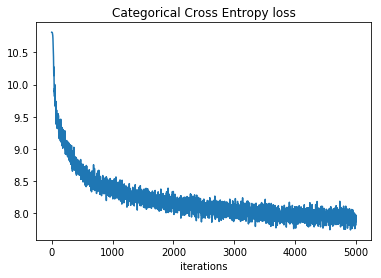

In [42]:
plt.figure()
plt.title("Categorical Cross Entropy loss")
plt.xlabel("iterations")
plt.plot(np.arange(len(losses)), losses)
plt.show()

### Embeddings analysis

Let's try to use TSNE to investigate what as been captured by the embeddings. We will use two projections: department and aisle. Indeed, we expect products sharing this feature to be bought together.

In [43]:
from matplotlib import pyplot as plt
tsne = TSNE(perplexity=30, n_components=2, init="pca", n_iter=5000)

def plot_embedding(embeddings, classes, sample_size=1000):
    subsample_idx = np.random.choice(embeddings.shape[0], sample_size, replace=False)            
    scaleFactor = 1    
    projected_embeddings = tsne.fit_transform(embeddings[subsample_idx,:]) 
    for class_name, prducts_class in classes.items():
        plt.figure(i)
        plt.title(class_name)
        classes_subsample = [prducts_class[idx] for idx in subsample_idx]
        sc = plt.scatter(scaleFactor*projected_embeddings[:,0], scaleFactor*projected_embeddings[:,1], c=classes_subsample, alpha=.1, cmap='Dark2')
        plt.colorbar(sc)
        plt.show()

In [44]:
department_mapping = {department:i for i,department in enumerate(departments_df.department.tolist())}
products_department = full_products_df.replace({"department":department_mapping}).sort_values(by="product_id").department.tolist()

aisle_mapping = {aisle:i for i,aisle in enumerate(aisle_df.aisle.tolist())}
products_aisle = full_products_df.replace({"aisle":aisle_mapping}).sort_values(by="product_id").aisle.tolist()

In [45]:
classes = {"department":products_department, "aisle":products_aisle}

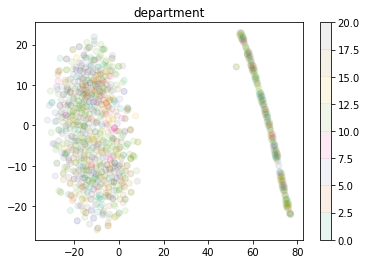

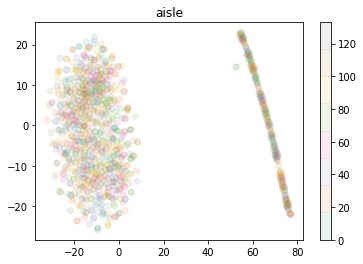

In [46]:
plot_embedding(embeddings=embeddings, classes=classes)

I was expecting to see groups of products sharing the same aisle in the TSNE decomposition as they are likely to be bought together. <br/>
However, there is no such decomposition, but rather two groups, which probably correspond to product popularity (requiring further investigation)